# What it says on the tin

If you assume that task space is meaningfully represented, you would assume that correct and incorrect (in the sense of being in the wrong place in the sequence) would be represented differently. It looks like that is not the case though, sadly.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import scipy.stats as stt
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)
clrs = seaborn.color_palette(n_colors=4)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [3]:

from mecll.rsync import Rsync_aligner
from mecll.load import load_data
from mecll.process_data.proc_beh import get_transitions_state, build_poke_df, get_in_task_pokes
from mecll.process_data.proc_neural import get_all_resps, get_mean_resps, get_activity_for_each_poke, get_within_and_across_correlations
from mecll.plot.plot_activity_on_graph import plot_activity_on_graph, plot_cell

# Actual code

In [4]:
from mecll.load import find_task_file

In [6]:
#Load behavioural data
root_path = '/Users/yves/team_mouse Dropbox/MEC_data/spike_sorted/2021-07-29_39955_ks25/'
#'/Users/yves/Downloads/example_files2_wOF//'

out = load_data(root_path)
spkT,spkC,single_units,events,lines,aligner = out

474 475


In [7]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

In [8]:
df = build_poke_df(lines,events)


In [9]:
all_spk_store = get_activity_for_each_poke(df,spkT,spkC,single_units,aligner)

In [10]:
all_spk_store.shape

(31, 1571)

In [11]:
store = []

n_neurons = all_spk_store.shape[0]

for neuron_ix in range(n_neurons):
    tmp2 = []
    for port_nr in range(9):
        tmp1 = []
        for task_nr in df.task_nr.unique():

            v = df.loc[(df['port']==port_nr) &
                       (df['reward']==True) & 
                       (df['correct']==True) & 
                       (df['task_nr']==task_nr)
                      ]['time']


            v2 = df.loc[(df['port']==port_nr) &
                       (df['reward']==False) & 
                       (df['correct']==True) & 
                       (df['task_nr']==task_nr)
                      ]['time']
            if neuron_ix==0:
                print(len(v.index),len(v2.index))
            mean_diff = np.nanmean(all_spk_store[neuron_ix,v.index])-np.nanmean(all_spk_store[neuron_ix,v2.index])
            tmp1.append(mean_diff)
        tmp2.append(tmp1)
    store.append(tmp2)

51 6
36 4
33 12
44 2
30 6
38 6
62 4
18 4
31 11
13 13
33 10
34 4
38 5
22 4
51 11
16 14
51 7
16 9


In [12]:
store_same = []

n_neurons = all_spk_store.shape[0]

for neuron_ix in range(n_neurons):
    tmp2 = []
    for port_nr in range(9):
        tmp1 = []
        for task_nr in df.task_nr.unique():

            is_correct = True
            v = df.loc[(df['port']==port_nr) &
                       (df['correct']==True) & 
                       (df['task_nr']==task_nr)
                      ]['time']

            n_fh = len(v.index)
            first_half_inds = int(np.floor(n_fh/2.))
            
            mean_diff = (np.nanmean(all_spk_store[neuron_ix,v.index[:first_half_inds]])-
                        np.nanmean(all_spk_store[neuron_ix,v.index[first_half_inds:]]))
            tmp1.append(mean_diff)
        tmp2.append(tmp1)
    store_same.append(tmp2)

In [13]:
store = np.array(store)
store_same = np.array(store_same)

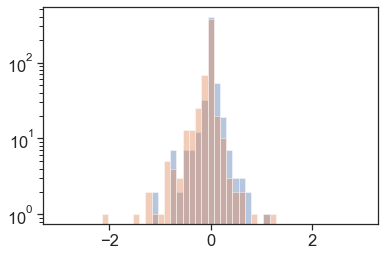

In [14]:
bns_ = np.linspace(-3,3,num=50)
seaborn.distplot(store.flatten(),kde=0,bins=bns_)
seaborn.distplot(store_same.flatten(),kde=0,bins=bns_)
plt.yscale('log')
#plt.ylim(0,100) 

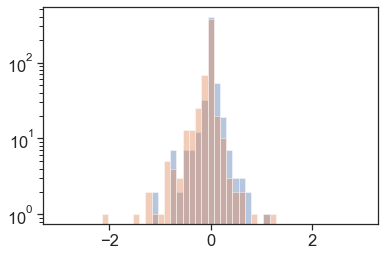

In [15]:
bns_ = np.linspace(-3,3,num=50)
seaborn.distplot(store.flatten(),kde=0,bins=bns_)
seaborn.distplot(store_same.flatten(),kde=0,bins=bns_)
plt.yscale('log')
#plt.ylim(0,100) 

In [16]:
np.var(store.flatten())

0.030277493872428812

In [17]:
np.var(store_same.flatten())

0.05251162378456262

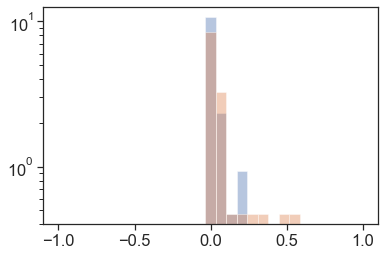

In [18]:
bns_ = np.linspace(-1,1,num=30)
seaborn.distplot(np.abs(np.nanmean(store,axis=(1,2))),kde=0,bins=bns_,norm_hist=1)
seaborn.distplot(np.abs(np.nanmean(store_same,axis=(1,2))),kde=0,bins=bns_,norm_hist=1)
plt.yscale('log')
#plt.ylim(0,100) 

Text(0, 0.5, 'Correct - Incorrect resps')

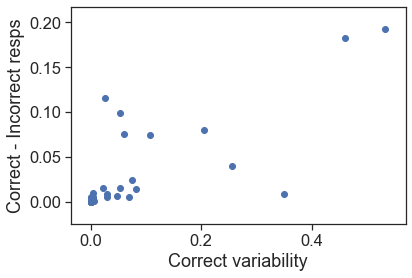

In [19]:
plt.scatter(np.abs(np.nanmean(store_same,axis=(1,2))),np.abs(np.nanmean(store,axis=(1,2))))
plt.xlabel("Correct variability")
plt.ylabel("Correct - Incorrect resps")

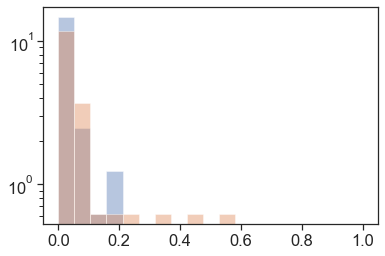

In [20]:
bns_ = np.linspace(0,1,num=20)
seaborn.distplot(np.abs(np.nanmean(store,axis=(1,2))),kde=0,bins=bns_,norm_hist=True)
seaborn.distplot(np.abs(np.nanmean(store_same,axis=(1,2))),kde=0,bins=bns_,norm_hist=True)
plt.yscale('log')
#plt.ylim(0,100) 

In [21]:
np.var(np.nanmean(store,axis=(1,2)))

0.0036850510442522706

In [22]:
np.var(np.nanmean(store_same,axis=(1,2)))

0.021666739166635127

In [23]:
stt.ks_2samp(np.abs(store.flatten()),np.abs(store_same.flatten()))

Ks_2sampResult(statistic=0.06630824372759857, pvalue=0.17196225405188212)

In [24]:
np.max(store)

1.0645833333333332

In [28]:
is_correct = False
v2 = df.loc[(df['port']==port_nr) &
           (df['correct']==is_correct) & 
           #(df['next_correct']==True) &
           #(df['reward']==True) &
           #(df['port_repeat']==False) & 
           (df['task_nr']==task_nr)
          ]['time']


In [29]:
np.mean(all_spk_store[5,v.index])

0.06

In [30]:
np.mean(all_spk_store[5,v2.index])

nan

In [31]:
stt.ks_2samp(all_spk_store[5,v.index],all_spk_store[5,v2.index])

Ks_2sampResult(statistic=0.04878048780487805, pvalue=0.999999999180252)

# Now compare orders of activation

In [12]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   (df['reward']==True) &
                   #(df['next_correct']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr),)
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]

            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

   

0 30 0
0 24 1
0 26 2
0 33 3
0 33 4
0 10 5
0 27 6
0 26 7
0 9 8


In [13]:
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

all_resps_g1,_ = get_mean_resps(all_resps_g1_single_trial)
all_resps_g2,_ = get_mean_resps(all_resps_g2_single_trial)


all_resps1_g1,_ = get_mean_resps(all_resps1_g1_single_trial)
all_resps1_g2,_ = get_mean_resps(all_resps1_g2_single_trial)

all_resps2_g1,_ = get_mean_resps(all_resps2_g1_single_trial)
all_resps2_g2,_ = get_mean_resps(all_resps2_g2_single_trial)

In [51]:
store = []

n_neurons = all_spk_store.shape[0]

for neuron_ix in range(n_neurons):
    tmp2 = []
    for port_nr in range(9):
        tmp1 = []
        for task_nr in df.task_nr.unique():

            is_correct = True
            v = df.loc[(df['port']==port_nr) &
                       (df['reward']==False) & 
                       (df['correct']==True) & 
                       (df['task_nr']==task_nr)
                      ]['time']


            v2 = df.loc[(df['port']==port_nr) &
                       (df['reward']==False) & 
                       (df['correct']==False) & 
                       (df['task_nr']==task_nr)
                      ]['time']
            
            mean_diff = [np.nanmean(all_spk_store[neuron_ix,v.index]),np.nanmean(all_spk_store[neuron_ix,v2.index])]
            tmp1.append(mean_diff)
        tmp2.append(tmp1)
    store.append(tmp2)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


In [52]:
store_same = []

n_neurons = all_spk_store.shape[0]

for neuron_ix in range(n_neurons):
    tmp2 = []
    for port_nr in range(9):
        tmp1 = []
        for task_nr in df.task_nr.unique():

            is_correct = True
            v = df.loc[(df['port']==port_nr) &
                       (df['correct']==True) & 
                       (df['task_nr']==task_nr)
                      ]['time']

            n_fh = len(v.index)
            first_half_inds = int(np.floor(n_fh/2.))
            
            mean_diff = (np.nanmean(all_spk_store[neuron_ix,v.index[:first_half_inds]]),
                        np.nanmean(all_spk_store[neuron_ix,v.index[first_half_inds:]]))
            tmp1.append(mean_diff)
        tmp2.append(tmp1)
    store_same.append(tmp2)

In [53]:
ccs_within,ccs_across,_ = get_within_and_across_correlations(all_resps1_g1,all_resps2_g1,
                                                             all_resps1_g2,all_resps2_g2,
                                                             all_resps_g1,all_resps_g2)

0.569387982362058
0.5683167131395044
0.4753307759607607


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [64]:
store = np.array(store)
store_same = np.array(store_same)

In [65]:
store2 = store.swapaxes(1,-1)
store_same2 = store_same.swapaxes(1,-1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


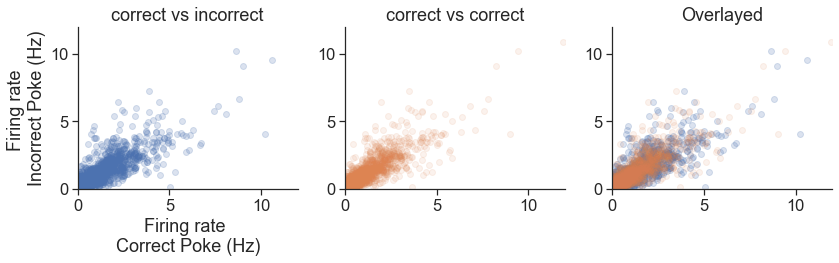

In [97]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("correct vs incorrect")

plt.scatter(store2.swapaxes(0,1).reshape(2,-1)[0],store2.swapaxes(0,1).reshape(2,-1)[1],alpha=.2)
plt.xlim(0,12)
plt.ylim(0,12)
plt.xlabel("Firing rate \nCorrect Poke (Hz)")
plt.ylabel("Firing rate \nIncorrect Poke (Hz)")

plt.subplot(1,3,2)
plt.title("correct vs correct")
plt.scatter(store_same2.swapaxes(0,1).reshape(2,-1)[0],store2.swapaxes(0,1).reshape(2,-1)[1],alpha=.1,c=clrs[1])
plt.xlim(0,12)
plt.ylim(0,12)

plt.subplot(1,3,3)
plt.title("Overlayed")

plt.scatter(store2.swapaxes(0,1).reshape(2,-1)[0],store2.swapaxes(0,1).reshape(2,-1)[1],alpha=.2)
plt.scatter(store_same2.swapaxes(0,1).reshape(2,-1)[0],store2.swapaxes(0,1).reshape(2,-1)[1],alpha=.1,c=clrs[1])

plt.xlim(0,12)
plt.ylim(0,12)

plt.tight_layout()
seaborn.despine()

In [74]:
r1 = store2.swapaxes(0,1).reshape(2,-1)[0]
r2 = store2.swapaxes(0,1).reshape(2,-1)[1]
ixs = np.isfinite(r1+r2)
np.corrcoef(r1[ixs],r2[ixs])

array([[1.        , 0.88748288],
       [0.88748288, 1.        ]])

In [75]:
r1 = store_same2.swapaxes(0,1).reshape(2,-1)[0]
r2 = store_same2.swapaxes(0,1).reshape(2,-1)[1]
ixs = np.isfinite(r1+r2)
np.corrcoef(r1[ixs],r2[ixs])

array([[1.        , 0.97021439],
       [0.97021439, 1.        ]])

In [57]:
store2.shape

(320, 2, 2, 9)

In [78]:
cross_neuron_ccs = []
for neuron_rates in store2.reshape([320,2,-1]):
    r1 = neuron_rates[0]
    r2 = neuron_rates[1]
    ixs = np.isfinite(r1+r2)
    cross_neuron_ccs.append(np.corrcoef(r1[ixs],r2[ixs])[0,1])
cross_neuron_ccs = np.array(cross_neuron_ccs)

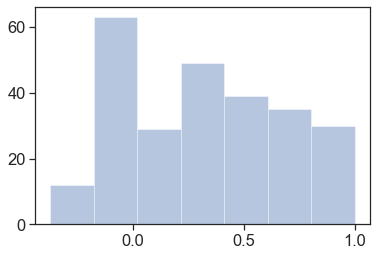

In [79]:
seaborn.distplot(cross_neuron_ccs[np.isfinite(cross_neuron_ccs)],kde=0)

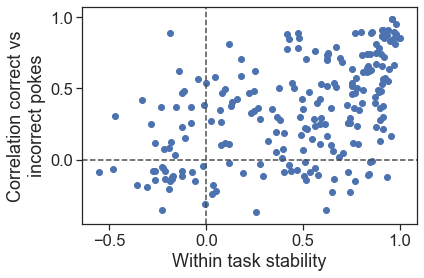

In [80]:
ixs = np.isfinite(cross_neuron_ccs)
plt.scatter(ccs_within[ixs],cross_neuron_ccs[ixs])
plt.xlabel("Within task stability")
plt.ylabel("Correlation correct vs\nincorrect pokes")
plt.axvline(x=0,color='.3',linestyle='--')
plt.axhline(y=0,color='.3',linestyle='--')


In [40]:
r2

array([ 0.        ,  0.015     , -0.01578947,  0.012     ,  0.        ,
        0.        ,  0.        , -0.01764706,  0.        ])

In [33]:
neuron_ix = 164
task_ix = 0
print(store2[neuron_ix,0,task_ix,:])
print(store2[neuron_ix,1,task_ix,:])

[1.95       1.60588235 1.24285714 1.92       0.925      0.075
 2.1375     0.66666667 1.4625    ]
[0.4        3.45       0.92727273 1.5        1.32       0.8
 2.1        0.35       2.1       ]


In [34]:
np.argsort(store2[neuron_ix,0,task_ix,:])

array([5, 7, 4, 2, 8, 1, 3, 0, 6])

In [35]:
np.argsort(store2[neuron_ix,1,task_ix,:])

array([7, 0, 5, 2, 4, 3, 8, 6, 1])

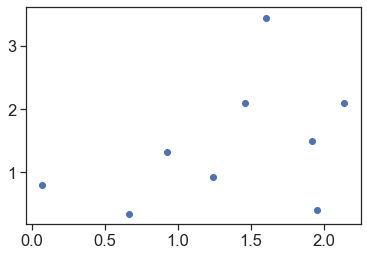

In [38]:
plt.scatter(store2[neuron_ix,0,task_ix,:],store2[neuron_ix,1,task_ix,:])